# Feature Importance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import shap
import warnings

warnings.filterwarnings("ignore")

In [2]:
%run featimp

## Overview

#### What is feature importance?

Feature importance ranks a model's features (independent/predictor variables) by their relative predictive strength within the given model.

#### Why do we care about feature importance? What is it used for?

Feature importance adds interpretability to the results of a model, especially for business intelligence reasons. For example, if a real estate company was predicting New York City apartment prices with a number of features, and it found that the number of bathrooms ranked high in feature importance, it could determine that the number of bathrooms may be important to renters and advertise number of bathrooms more clearly in their listings. Knowing what drives your target (dependent) variable can help drive business decisions. 

Feature importance is also useful in feature selection. Let's say you have 100 features that may help predict a target. Do you need all these features in your predictions? Which are the most important to keep-- ones that contribute the most to your predictions? Additionally, are all your features helping your model, or are some of them hurting it or have no predictive power (as if you added a random irrelevant feature)? Feature importance can help you select features in a way that simplifies and improves your model.


#### How do you measure feature importance?

There are many different ways to measure feature importance, each with their upsides and downsides. There is no one definitive measure: It may be best to implement and compare results from multiple methods, or experiment with the suggested features from multiple paradigms. Additionally, we should treat feature importance as suggestions or added color, rather than gospel, and look at relative ranks of feature importances rather than their exact number values. 

#### Overview of report

In this report, we will discuss and compare the following methods:
    1. Spearman correlation coefficient importance
    2. Drop-column importance
    3. Permutation importance

For illustration, we will be looking at Scikit-learn's [California housing dataset](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset) for regression models, and [the Wisconsin breast cancer dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) for classification models (see links for data dictionary and description). 

For models, we will be using RandomForestRegressor and RandomForestClassifier from Scikit-learn as examples, and to evaluate them, we will use mean squared error (MSE) and F1 score, respectively.

In [3]:
ca = fetch_california_housing()
ca_df = pd.DataFrame(ca.data, columns=ca.feature_names)
ca_df["MedV"] = ca.target

X_ca = ca_df.drop("MedV", axis=1)
y_ca = ca_df["MedV"]

print(ca_df.shape)
ca_df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedV
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df["diagnosis"] = cancer.target

X_cancer = cancer_df.drop("diagnosis", axis=1)
y_cancer = cancer_df["diagnosis"]
print(cancer_df.columns)
print(cancer_df.shape)
cancer_df.head()

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'diagnosis'],
      dtype='object')
(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Method Evaluation and Comparison Techniques

#### Adding a random column
One way to evaluate whether we should use a recommended feature is to add a random noise feature to the model. This feature is literally filled with randomly generated values, and is meant to be a feature that has no defined relationship with the target: Maybe there is some random negative or positive correlation between the two, but it is meant to be a non-predictive, unimportant variable. **When looking at feature importances, you can add a random column and choose to ignore any features that do worse than it in the ranking.** In this report, we add a random column to our features for evaluation.

#### Calculating empirical variance
How confident are we in our feature importance calculations? How much of it depends on the sample of data we use? We can estimate variance empirically by bootstrapping the data and recalculating importances. In this report, we will calculate a 2-standard-deviation error bar for our feature importance estimations in this way. The values you'll see as the feature importances are normalized to between 0 and 1, and are the mean of the feature importances from all simulations.

#### Same model and metric with different k top features from different feature importance methods
How do we compare across feature importance methods? We can do this by picking the k top features suggested by each feature importance method, training a model with those features, and comparing the performances of these models based on a selected metric. We will do this to compare models in this report.

## Spearman Correlation Coefficient Importance

#### What is it?
A measure of feature importance using the absolute value of the [Spearman correlation coefficient](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html) between each feature and the target (see link for details).


#### Procedure
1. Calculate Spearman rank-order correlation coefficients between each feature x and target y (their values will be between -1 and 1)
2. Take absolute value of coefficients (their values will now be between 0 and 1)
3. Rank features from biggest to smallest absolute coefficient. The features' relative rank is their feature importance order.

#### Pros and Cons
*Pros:*<br>
• Easy to understand<br>
• Simple implementation<br>
• Model-indepedent (and works for any machine learning model<br>
• Does not assume normal distribution of data (unlike Pearson correlation coefficient)<br>
• Does not require linear relationship (unlike Pearson correlation coefficient)

*Cons:*<br>
• Only shows monotonic relationships between feature and target<br>
• Less effective with codependent features (works best with independent features): Features with similar relationships to the target get similar ranks


#### How to interpret
• 0 means there is no relationship between the feature and target; values close to 0 are unimportant<br>
• Since -1 means there is a direct negative monotonic relationship between x and y, we consider the absolute value of the Spearman correlation coefficient (i.e. if there is a near -1 coefficient between x and y, the feature is very predictive since when x goes up, y goes down, and vice versa)
• Codependent features which have similar relationships with the target may get similar ranks

NOTE: To correctly correspond to model-dependent methods, use X_train and y_train for all (rather than full dataset). Setting the same random_state will ensure split is same for every method.

In [5]:
X_train_ca, _, y_train_ca, _ = train_test_split(X_ca, y_ca, test_size=0.2, random_state=42)

Let's first see the relative importances calculated on the original data.

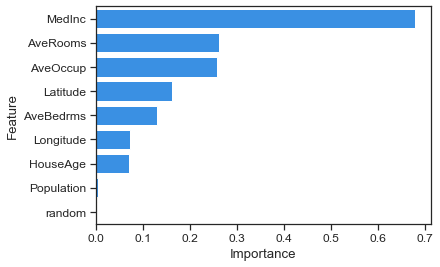

In [6]:
spearman_imp_ca = spearman_imp(add_random_noise_col(X_train_ca), y_train_ca, sort=True)
plot_imp(spearman_imp_ca, errorbar=False)

Now, let's see the importances calculated on simulations using bootstrapped data.

NOTE: As mentioned above, values here will be between 0 and 1, as values have been normalized. However, since we are only concerned with the rank order, exact values do not matter, only relative values do.

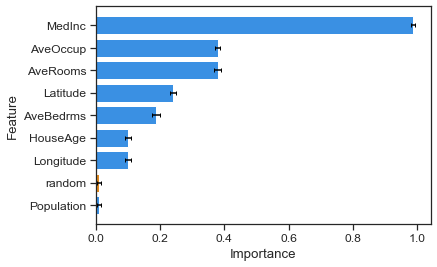

In [7]:
spearman_imp_ca_sim = simul_imp(30, spearman_imp, add_random_noise_col(X_train_ca), y_train_ca)
plot_imp(spearman_imp_ca_sim)

Let's see the same for the cancer dataset.

In [8]:
X_train_cancer, _, y_train_cancer, _ = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

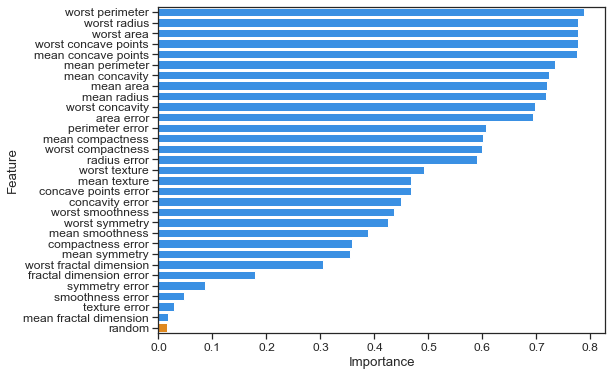

In [9]:
spearman_imp_cancer = spearman_imp(add_random_noise_col(X_train_cancer), y_train_cancer, sort=True)
plot_imp(spearman_imp_cancer, errorbar=False, big=True)

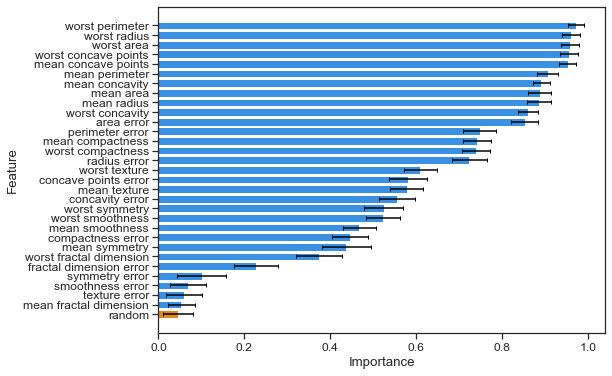

In [10]:
spearman_imp_cancer_sim = simul_imp(30, spearman_imp, add_random_noise_col(X_train_cancer), y_train_cancer)
plot_imp(spearman_imp_cancer_sim, big=True)

## Drop-Column Importance

#### What is it?
A measure of how important a feature is to a model by dropping it and seeing how it affects a given model's overall performance on a chosen metric

#### Procedure:
1. Train a model on all features, and compute metric using validation set as a baseline
2. Drop column (feature) $x_{i}$
3. Retrain model on all features except $x_{i}$, and recompute metric using validation set
4. The drop in the metric from the baseline is feature $x_{i}$'s importance
5. Calculate the drop in metric for all features. The relative ranks are the feature importances<br>

*NOTE: When using a metric you are trying to minimize (such as MSE), calculate a feature's importance as (metric without feature) - baseline, rather than baseline - (metric without feature).*

#### Pros and Cons

*Pros:*<br>
• Easy to understand<br>
• Simple implementation<br>
• Direct measure of feature importance and highly interpretable ("If you drop this feature, how much worse does the model do?")<br>
• Works for any machine learning model<br>

*Cons:*<br>
• Computationally expensive to retrain model k times for k features<br>
• Codependent features result in zero or low importance: Need a separate method to figure out which features are codependent together, and which are independent but unimportant<br>

#### How to interpret
• Negative drop-column importance: Feature hurts model performance, and dropping it may help model performance<br>
• Zero or near zero importance: May be unimportant features or there are 2 or more very codependent features (e.g. if there are 2 codependent variables, if one is dropped, the other covers

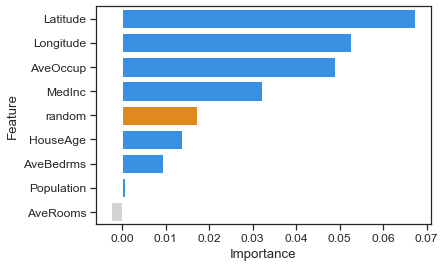

In [11]:
drop_col_imp_ca = drop_col_imp(add_random_noise_col(X_train_ca), y_train_ca, 
                               RandomForestRegressor(min_samples_leaf=50),
                               mean_squared_error, neg_metric=True, sort=True)
plot_imp(drop_col_imp_ca, errorbar=False)

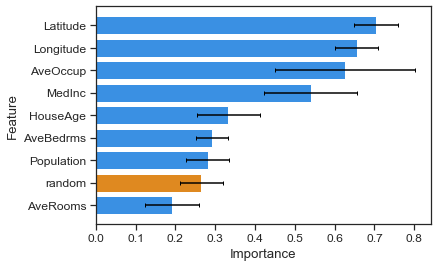

In [12]:
drop_col_imp_ca_sim = simul_imp(30, drop_col_imp, add_random_noise_col(X_train_ca), y_train_ca,
                                RandomForestRegressor(min_samples_leaf=50),
                                mean_squared_error, neg_metric=True)
plot_imp(drop_col_imp_ca_sim)

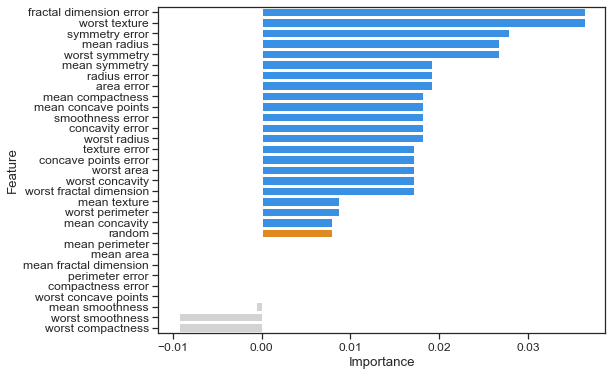

In [13]:
drop_col_imp_cancer = drop_col_imp(add_random_noise_col(X_train_cancer), y_train_cancer, 
                                   RandomForestClassifier(min_samples_leaf=5),
                                   f1_score, sort=True)
plot_imp(drop_col_imp_cancer, errorbar=False, big=True)

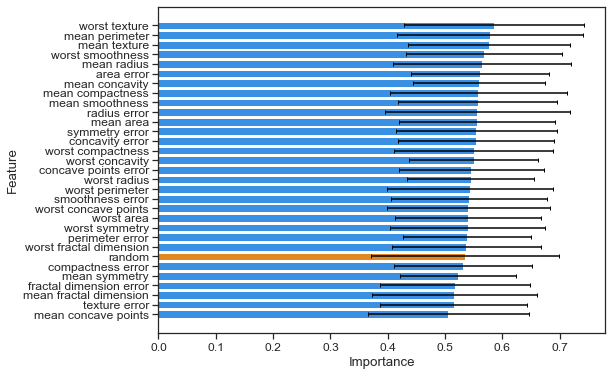

In [14]:
drop_col_imp_cancer_sim = simul_imp(30, drop_col_imp, add_random_noise_col(X_train_cancer), y_train_cancer,
                                    RandomForestClassifier(min_samples_leaf=5),
                                    f1_score)
plot_imp(drop_col_imp_cancer_sim, big=True)

## Permutation Importance

#### What is it?
A measure of feature importance calculated by permuting a feature (shuffling the order of its observations to break its relationship with the target).

#### Procedure:
1. Train a model on all features, and compute metric using validation set as a baseline
2. Shuffle column (feature) $x_{i}$
3. Recompute metric using validation set (WITHOUT retraining the model beforehand)
4. The drop in the metric from the baseline is feature $x_{i}$'s importance
5. Calculate the drop in metric for all features. The relative ranks are the feature importances

#### Pros and Cons

*Pros:*<br>
• Easy to understand<br>
• Simple implementation<br>
• Works for any machine learning model<br>
• More efficient computationally than drop column importance: No need to retrain model for every feature<br>

*Cons:*<br>
• Shuffling can create nonsensical records (e.g. sex=male, pregant=True) that may may the results suspect<br>
• Codependent features tend to share importance: Need a separate method to figure out which features are codependent together, and which are independent but unimportant<br>
• May overestimate the importance of codependent features<br>

#### How to interpret
• Negative drop-column importance: Feature hurts model performance, and dropping it may help model performance<br>
• Codependent features will share importance (e.g. if there are 2 strongly codependent features, their importance will be halved)

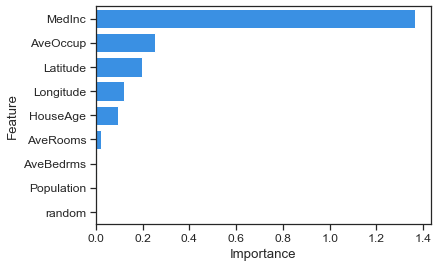

In [15]:
permutation_imp_ca = permutation_imp(add_random_noise_col(X_train_ca), y_train_ca, 
                                     RandomForestRegressor(min_samples_leaf=50),
                                     mean_squared_error, neg_metric=True, sort=True)
plot_imp(permutation_imp_ca, errorbar=False)

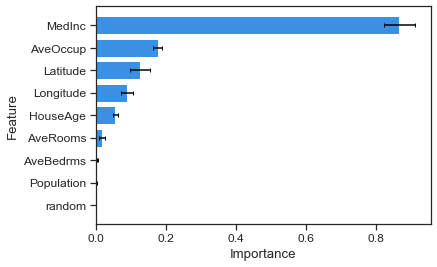

In [16]:
permutation_imp_ca_sim = simul_imp(30, permutation_imp, add_random_noise_col(X_train_ca), y_train_ca,
                                   RandomForestRegressor(min_samples_leaf=50),
                                   mean_squared_error, neg_metric=True)
plot_imp(permutation_imp_ca_sim)

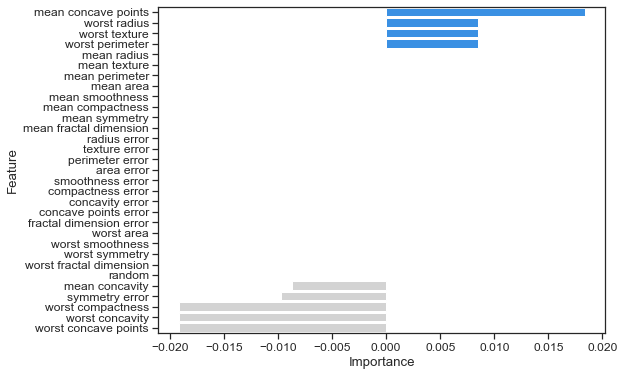

In [17]:
permutation_imp_cancer = permutation_imp(add_random_noise_col(X_train_cancer), y_train_cancer, 
                                         RandomForestClassifier(min_samples_leaf=5),
                                         f1_score, sort=True)
plot_imp(permutation_imp_cancer, errorbar=False, big=True)

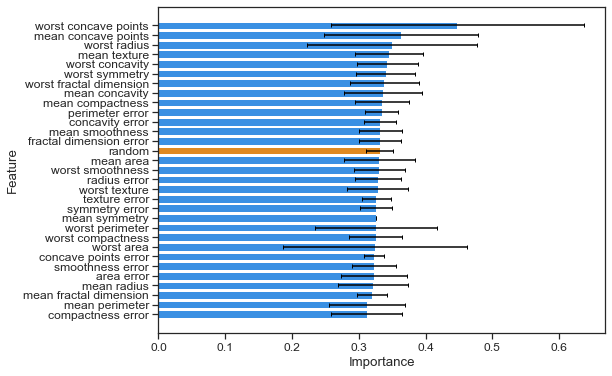

In [18]:
permutation_imp_cancer_sim = simul_imp(30, permutation_imp, add_random_noise_col(X_train_cancer), y_train_cancer,
                                       RandomForestClassifier(min_samples_leaf=5),
                                       f1_score)
plot_imp(permutation_imp_cancer_sim, big=True)

## Compare feature importances

Let's compare the relative strength of feature importances by running RandomForestRegressor on the top 3 California housing features for each method, and RandomForestClassifier on the top 10 features for each method (top 1/3 of features for each dataset). Then, we'll evaluate by MSE and F1 score, respectively, to see which feature importance method's top k features resulted in the best performing model.

For consistency, we'll look at the top k features as selected from simulations, ignoring the random column.

California housing dataset: Regression with Random Forest

In [19]:
ranking_dfs = [spearman_imp_ca_sim, drop_col_imp_ca_sim, permutation_imp_ca_sim]
compare_imp_kfeat(3, ranking_dfs, X_ca, y_ca, RandomForestRegressor(), mean_squared_error, neg_metric=True)

,Method,Metric,Top Features Used
1,Drop-col,0.308,"[Latitude, Longitude, AveOccup]"
2,Permutation,0.460,"[MedInc, AveOccup, Latitude]"
0,Spearman,0.587,"[MedInc, AveOccup, AveRooms]"


For k=3 (top 1/3 of the 9 features), we found that drop-column importance performed the best on mean squared error, followed by permutation and Spearman. This makes sense as the first two methods were feature importancess specific to RandomForestRegressor, while Spearman was a model-independent feature selection method. However, we can see that the three methods share some top features.

Cancer dataset: Classification with Random Forest

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

ranking_dfs = [spearman_imp_cancer_sim, drop_col_imp_cancer_sim, permutation_imp_cancer_sim]
compare_imp_kfeat(10, ranking_dfs, X_cancer, y_cancer, RandomForestClassifier(), f1_score)

,Method,Metric,Top Features Used
0,Spearman,0.053,"[worst perimeter, worst radius, worst area, worst concave points, mean concave points, mean perimeter, mean concavity, mean area, mean radius, worst concavity]"
2,Permutation,0.053,"[worst concave points, mean concave points, worst radius, mean texture, worst concavity, worst symmetry, worst fractal dimension, mean concavity, mean compactness, perimeter error]"
1,Drop-col,0.035,"[worst texture, mean perimeter, mean texture, worst smoothness, mean radius, area error, mean concavity, mean compactness, mean smoothness, radius error]"


For k=10 (top 1/3 of the 30 features), we found that Spearman and permutation importance performed about equally well (or poorly!), followed by drop-column importance. We can also see that the three methods share some top features.

## Conclusion and Extensions

Feature importance is a broad topic with lots of areas to explore. In this report, we looked at Spearman correlation coefficient, drop column and permutation importance, showing a variety of options in feature importance methods and their pros and cons. 

Other feature importance methods include PCA and SHAP (SHapley Additive exPlanations).

When comparing feature importances across methods, we can choose different values of top k features to use-- some methods may be better at certain k than others.

The feature importance methods we looked at can be negatively affected by interdependence between features. We can use methods like Minimal Redundancy, Maximal Relevance (mRMR) to take account of redundancy between features. mRMR is a feature selection framework that takes account of both the relevance of each feature (the strength of relationship between the feature and the target by some metric) and reduces it by an average measure of redundancy (the strength of relationship between the feature and every other feature in a set of features):
$$J_{mRMR}(x_{k}) = I(x_{k}, y) - \dfrac{1}{|S|}\sum_{x_{j}\in S}I(x_{k}, x_{j})$$
(for some metric of relationship I() (e.g. Spearman's coefficient) and subset of features S (could be all of the features available)